In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from pandas_profiling import ProfileReport
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train['train'] = 1   
test['train'] = 0    
test['default'] = -1  
data = train.append(test, sort=False).reset_index(drop=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

110148 записей, 20 признаков. 

In [5]:
data.default.value_counts()

 0    64427
-1    36349
 1     9372
Name: default, dtype: int64

 Целевая переменная несбалансирована, 9372 дефолтных клиента против 64427 недефолтных.

## EDA
*** Использовался Pandas Profile, и ноутбуки из кеггла.
* В наборе даных 19 признаков
* Всего представлено 110 148 записей
* Количество пропусков 0.04%, только в признаке education
* Дубликатов нет
* client_id не имеет повторяющихся значений, все значения уникальные
* app_date только 120 вариантов признака (0.1%). Большинство данных за период февраль-апрель 2014 года
* education содержит 5 категорий:
1. SCH (52%) - School;
2. GRD (31%) - Graduated (Master degree);
3. UGR (13%) - UnderGraduated (Bachelor degree);
4. PGR (1.7%) - PostGraduated;
5. ACD (0.3%) - Academic Degree.
* sex содержит 2 вариации признака:
1. Female (56%);
2. Male (44%);
* age представлен конкретными значениями со смещением влево:
-- Minimum 21
-- median 37
-- Mean 39.2
-- Maximum 72
-- Interquartile range (IQR) 18
* car бинарный признак, 67% заемщиков не имеют автомобиля
* car_type бинарный признак, показывающий отечественный или иностранный автомобиль у заемщика. 81% заемщиков имеют отечественный автомобиль
decline_app_cnt модержит конкретные значения со смещением влево. Большинство значений (83%) нулевые. Преобладающее большинство наблюдений в промежутке от 0 до 6
-- Maximum 33

* good_work Mбольшинство заемщиков не имеют хорошей работы (83%)
* score_bki 93% значений уникальны, распределение нормальное, присутствуют отрицательные значения.
* bki_request_cnt натуральыне числа, которые варбируются от 0 до 53 с медианой 1. Большинство значений в промежутке от 0 до 8
* region_rating варбируются между 20 и 80. Категориальный признак. Самое часто встречающееся значение 50 (37%)
* home_address, work_address категориальные признаки с 3 вариациями.

* income большой разброс значений от 1000 до 1000000; можно попробовать либо превратить в категориальный признак, либо прологарифмировать

* sna / first_time категориальные признаки с 4 вариациями значений

* foreign_passport бинарный признак, 67% заемщиков имеют заграничный паспорт

* default целевой признак. Бинарный признак с подавляющим большинством тех, кто возвращает кредит без проблем. Выборка несбалансированная, при моделировании нужно будет попробовать undersampling.

Разделим признаки

In [6]:
# exclude client_id, app_date, default, sample

num_cols = [
    'age', 
    'decline_app_cnt', 
    'score_bki',
    'income', 
    'bki_request_cnt'
]

cat_cols = [
    'education', 
    'work_address', 
    'home_address', 
    'region_rating' , 
    'sna', 
    'first_time'
]

bin_cols = [
    'sex', 
    'car', 
    'car_type', 
    'good_work', 
    'foreign_passport'
]

Количественные признаки

<Figure size 432x288 with 0 Axes>

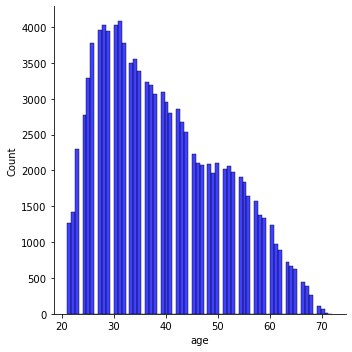

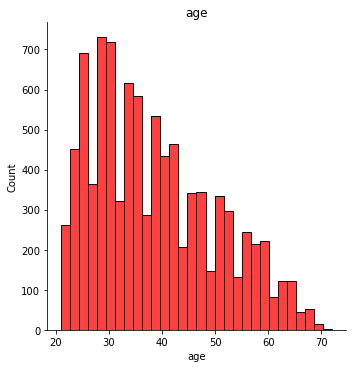

<Figure size 432x288 with 0 Axes>

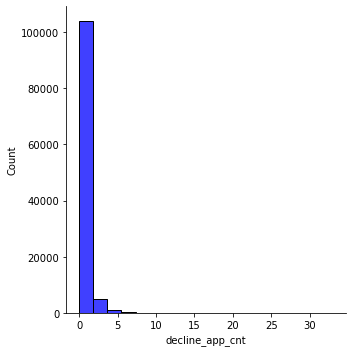

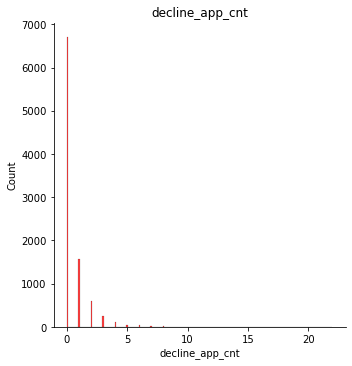

<Figure size 432x288 with 0 Axes>

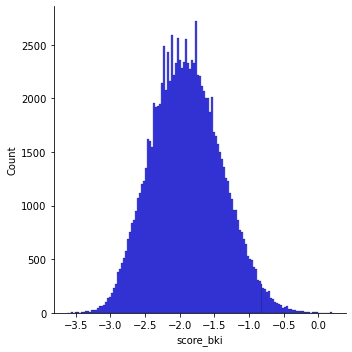

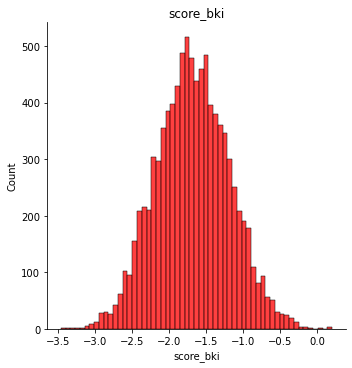

<Figure size 432x288 with 0 Axes>

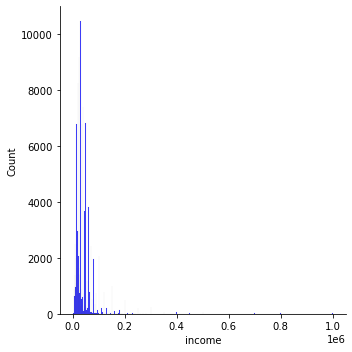

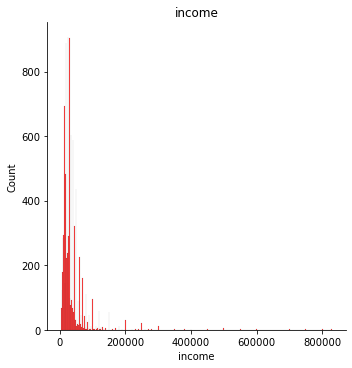

<Figure size 432x288 with 0 Axes>

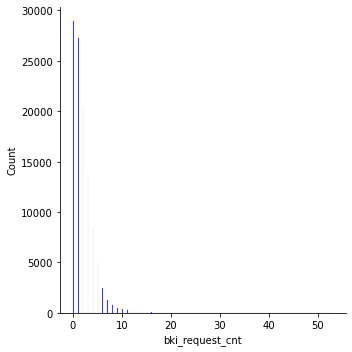

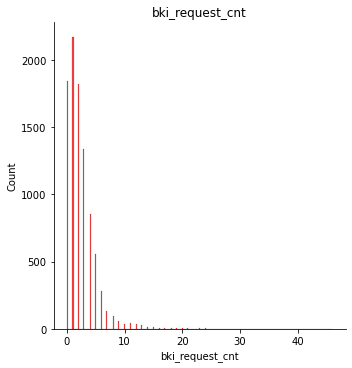

In [7]:
for i in num_cols:
    plt.figure()
    sns.displot(data[i], kde = False, rug=False, color = 'b')
    sns.displot(data[i][data['default'] == 1], kde = False, color = 'r',rug=False)
    plt.title(i)
    plt.show()

Распределения чисорвых параметров для дефолтных клинетов как и для всех имеет приблизительно тот же характер

дефолт больше характерен для более молодых

высокий score_bki характерен для дефолта

рейтинг региона влияет на целевую переменную

частые запросы в БКИ более характерны для дефолтных клиентов

в среднем, более высокий доход свидетельствует о меньшей вероятности дефолта

## Категориальные признаки

Клиенты с более низким уровнем образования чаще подвержены дефолту. В то же время, они чаще берут кредиты.

Чем ниже рейтинг региона, тем чаще возникает дефолт по кредитам. Но это неверно для двух наименее рейтинговых регионов.

Домашний и рабочий адреса распределены схожим образом. Возможно, есть мультиколлинеарность.

Категории sna: ниже категория - меньше дефолтов. First_time - аналогично.

In [8]:
# заполним пропуски наиболее часто встречающимся значением
data.education = data.education.fillna("SCH")

<AxesSubplot:title={'center':'Distribution of Education level by Region'}, xlabel='education', ylabel='region_rating'>

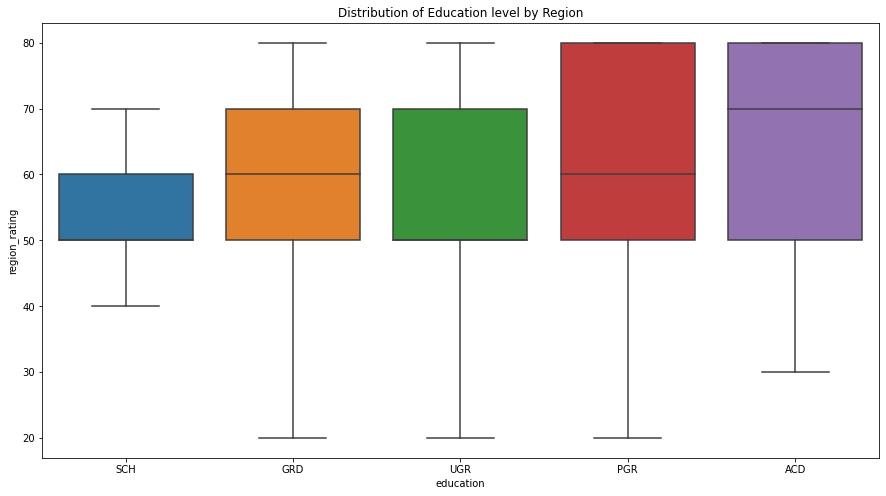

In [9]:
# оценим влияние региона проживания на уровень образования
plt.figure(figsize=(15, 8))
plt.title('Distribution of Education level by Region')
sns.boxplot(
    x="education", 
    y="region_rating", 
    data=data, 
    showfliers=False
)

Люди с более высоким уровнем образования живут в регионах с более высоким рейтингом. И наоборот.

<AxesSubplot:title={'center':'Distribution of Income by Education level'}, xlabel='education', ylabel='income'>

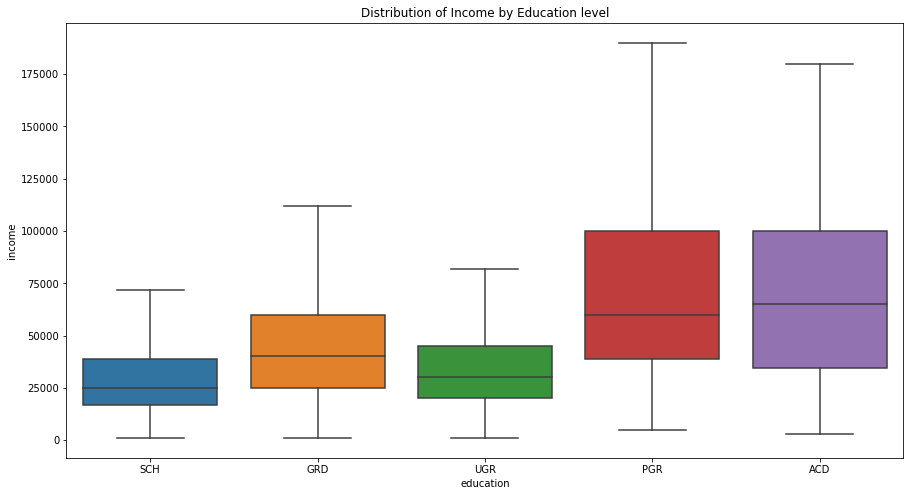

In [10]:
# оценим доход от уровня образования
plt.figure(figsize=(15, 8))
plt.title('Distribution of Income by Education level')
sns.boxplot(
    x="education", 
    y="income", 
    data=data, 
    showfliers=False
)

чем выше уровень образования тем выше зарабтоток

In [11]:
mappc = {}
label_encoder = LabelEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mappc[col] = dict(enumerate(label_encoder.classes_))
    
print(mappc)

{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}, 'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'region_rating': {0: 20, 1: 30, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}


## Бинарные признаки

Женщины чаще берут кредиты, чем мужчины. Относительное количество дефолтов при этом практически одинаковое.

Заемщики, у которых есть машина, более надежны. 

Заемщики, у которых иностранный автомобиль, более надежны, чем заемщики с отечественными машинами. Далее попробуем объединить два признака и сделать новый категориальный - не имеет машины, имеет отечественную машину, имеет иностранную машину.

Заемщики с хорошей работой и заграничным паспортом возвращают долг чаще, чем противоположные группы.

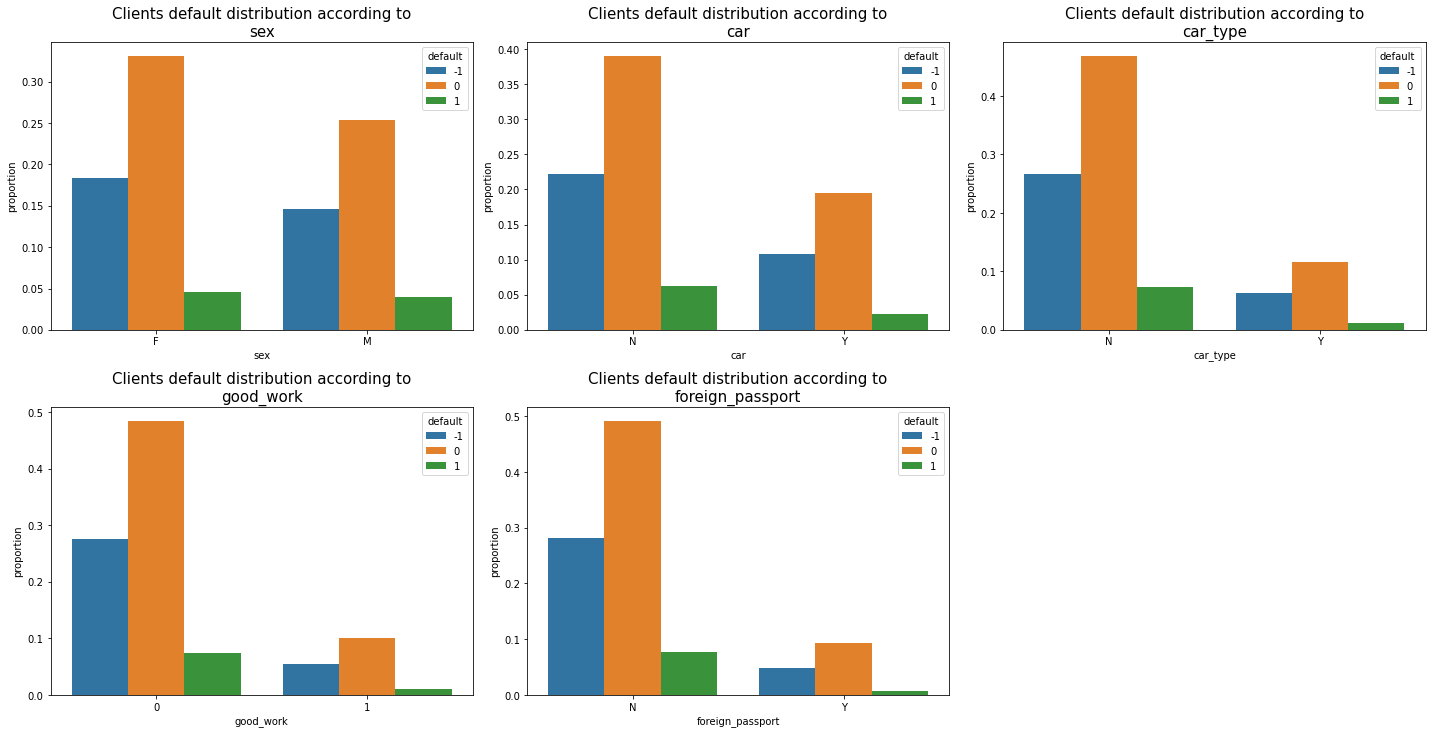

In [12]:
# посмотрим на распределение дефолтных состояний по различным признакам

plt.figure(figsize=[20, 20])
i = 1

for k in bin_cols:
    plt.subplot(4, 3, i)
    sns.barplot(
        x=k,
        y='proportion',
        hue='default',
        data=data[[k, 'default']].value_counts(normalize=True).rename('proportion').reset_index()
    )
    plt.title('Clients default distribution according to\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [13]:
# закодируем бинарные признаки

mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))
    
print(mapp)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}


## Корреляционный анализ

Слабая корреляция между всем параметрами и целевой переменной

Существенная корреляция между домашним адресом и местом работы. Можно попробовать удалить один из признаков.

Сильная корреляция между car, car_type. Отсутствие автомобиля и соответственное отсутствие признака, что автомобиль иностранный. Далее скомбинируем два столбца в один, преобразовав в новый категориальный признак. Так мы уменьшим размерность набора данных, но не потеряем информацию.

Есть довольно сильная обратная зависимость между sna, first_time.

Наиболее статистически значимые признаки - Score_bki, decline_app_cnt. 

<AxesSubplot:>

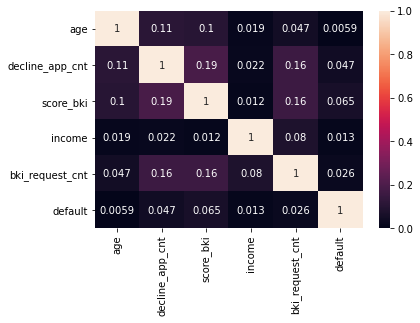

In [14]:
sns.heatmap(data[num_cols + ['default']].corr().abs(), vmin=0, vmax=1, annot= True)

<AxesSubplot:>

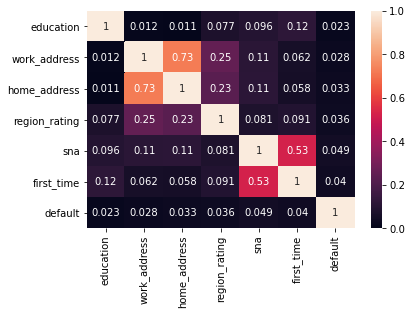

In [15]:
sns.heatmap(data[cat_cols + ['default']].corr().abs(), vmin=0, vmax=1, annot= True)

<AxesSubplot:>

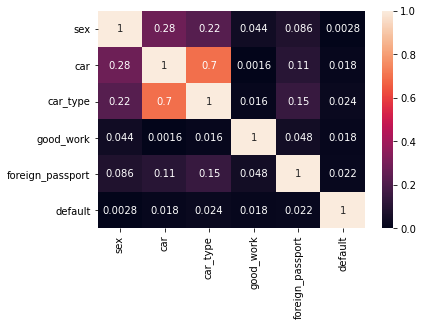

In [16]:
sns.heatmap(data[bin_cols + ['default']].corr().abs(), vmin=0, vmax=1, annot= True)

Наивная моедль для существущего датасета

Для построения наивной модели воспользуемся Логистической регрессией с базовыми параметрами,

удалим столбцы с датой

In [17]:
df = data.drop(['app_date'], axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

Выделим тренеровочнфй дата сет через- признак train

Уберем столбцы с клиентами, столбец train and целевой переменной

Разделем тренеровочные дынне на обучающие и тестовые

Обучим модель

Построим параметры качества

In [19]:
X = df[df['train']==1].drop(['client_id', 'train', 'default'], axis = 1)

In [20]:
Y=  df[df['train']==1]['default'].values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [22]:
# from sklearn.model_selection import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

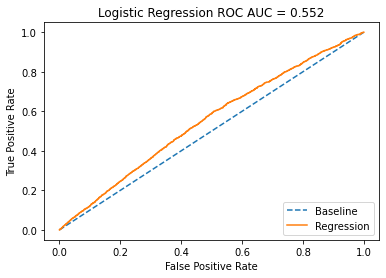

In [23]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [24]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
def show_metrics(y_test, y_pred, probs):
    print('accuracy_score:\t\t {:.4}'.format(accuracy_score(y_test, y_pred)))
    print('precision_score:\t {:.4}'.format(precision_score(y_test, y_pred, zero_division=0)))
    print('recall_score:\t\t {:.4}'.format(recall_score(y_test, y_pred, zero_division=0)))
    print('f1_score:\t\t {:.4}'.format(f1_score(y_test, y_pred, zero_division=0)))
    print('roc_auc_score:\t\t {:.4}'.format(roc_auc_score(y_test, probs)))
    
def conf_matrix(y_test, y_pred, model):
    print(model)
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default', 'default']).plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [26]:
show_metrics(y_test, y_pred, probs)

accuracy_score:		 0.8762
precision_score:	 0.0
recall_score:		 0.0
f1_score:		 0.0
roc_auc_score:		 0.5517


LogisticRegression()


<Figure size 432x288 with 0 Axes>

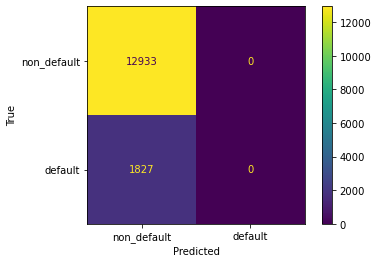

In [27]:
conf_matrix(y_test, y_pred, model)

В наивной модели мы вообще ничего не угадали из дефолтных клиентов. Вероятность угадывания примерно такая же как при подбрасывании монетки. Но так как благонадежных заемщиков всетаки больше, чем неблагонадежных, модель показывает высокий уровень точности. 

accuracy_score:		 0.8762

precision_score:	 0.0

recall_score:		 0.0

f1_score:		 0.0

roc_auc_score:		 0.5517
    

### Создание новых признаков

In [28]:
# получим кол-во дней от "начала эпохи" датасета
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
data_min = min(data['app_date'])
data['days'] = (data['app_date'] - data_min).dt.days.astype('int')
data['day'] = data['app_date'].dt.day
data['month'] = data['app_date'].dt.month

data.drop(['app_date'],  axis = 1, inplace = True)

# средний доход для конкретного возраста
mean_income = data.groupby('age')['income'].mean().to_dict()
data['mean_income_age'] = data['age'].map(mean_income)

# максимальный доход для конкретного возраста
max_income = data.groupby('age')['income'].max().to_dict()
data['max_income_age'] = data['age'].map(max_income)

# минимальный доход для конкретного возраста
min_income = data.groupby('age')['income'].min().to_dict()
data['min_income_age'] = data['age'].map(min_income)

# нормализуем доход
data["normalized_income"] = abs((data.income - data.mean_income_age)/data.max_income_age)
data.drop(['mean_income_age', 'max_income_age'],  axis = 1, inplace = True)

# среднее кол-во запросов в БКИ по конкретному возрасту
mean_bki = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_requests_age'] = data['age'].map(mean_bki)

# максимальное кол-во запросов в БКИ по конкретному возрасту
max_bki = data.groupby('age')['bki_request_cnt'].max().to_dict()
data['max_requests_age'] = data['age'].map(max_bki)

# нормализуем requests
data["normalized_req"] = abs((data.bki_request_cnt - data.mean_requests_age)/data.max_requests_age)
data.drop(['mean_requests_age', 'max_requests_age'],  axis = 1, inplace = True)

# среднее кол-во запросов в БКИ в зависимости от дохода
mean_bki_inc = data.groupby('income')['bki_request_cnt'].mean().to_dict()
data['mean_requests_income'] = data['income'].map(mean_bki_inc)

# средний доход по региону
mean_income_rat = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_rat)

data.drop(['income'],  axis = 1, inplace = True)

# сократим размерность матрицы без потери информации
# 0 - нет машины, 1 - есть отечественна машина, 2 - есть иномарка
data['car_comb'] = data['car'] + data['car_type']
data['car_comb'] = data['car_comb'].astype('category')
data.drop(['car', 'car_type'], axis=1, inplace=True)

    
# Sort out decline_app_cnt and bki_request_cnt by groups:
data['decline_cat'] = data['decline_app_cnt'].apply(lambda x: 4 if x >= 4 else x) 
data['bki_request_cat'] = data['bki_request_cnt'].apply(lambda x: 6 if x >= 6 else x)
data.drop(['decline_app_cnt', 'bki_request_cnt'], axis=1, inplace=True)

# Декомпозиция адресов

# вытащим два столбца из датасета
data_addresses = data[['work_address', 'home_address']].values

# создадим Scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_addresses)

# У нас два вектора. Сократим до одного, оставив наиболее значимую информацию.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
data['pca_address'] = pca_data
data['pca_address'] = data['pca_address'] + 5
data['pca_address'] = data['pca_address'].apply(lambda x: np.log(x) + 1)

# удалим ненужные столбцы
data.drop(['home_address','work_address'], axis=1, inplace=True)

# fix 2 zeros in normalized_req
data = data.fillna(data.mean())


In [29]:
num_cols = [
    'score_bki',
    'days',
    'min_income_age',
    'normalized_income',
    'normalized_req',
    'mean_requests_income',
    'mean_income_region',
]
cat_cols = [
    'education',
    'region_rating',
    'sna',
    'first_time',
    'car_comb',
    'decline_cat',
    'bki_request_cat',
    'pca_address',
]
bin_cols = [
    'sex',
    'good_work',
    'foreign_passport',
]

In [30]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [31]:
scaler = RobustScaler()
data[num_cols] = scaler.fit_transform(data[num_cols].values)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 60 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   client_id                       110148 non-null  int64  
 1   sex                             110148 non-null  int64  
 2   age                             110148 non-null  int64  
 3   good_work                       110148 non-null  int64  
 4   score_bki                       110148 non-null  float64
 5   foreign_passport                110148 non-null  int64  
 6   default                         110148 non-null  int64  
 7   train                           110148 non-null  int64  
 8   days                            110148 non-null  float64
 9   day                             110148 non-null  int64  
 10  month                           110148 non-null  int64  
 11  min_income_age                  110148 non-null  float64
 12  normalized_incom

Корреляционный анализ после изменения данных.

<AxesSubplot:title={'center':'Correlation Matrix of dataset features'}>

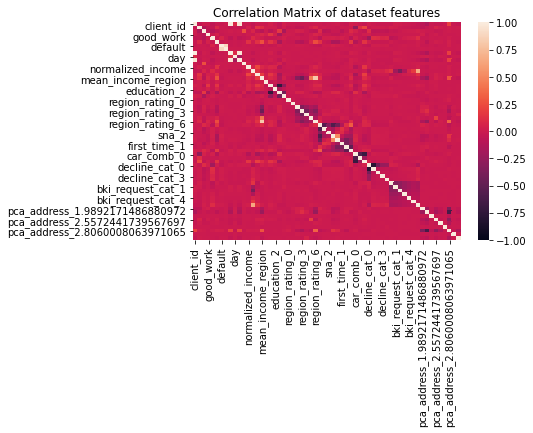

In [33]:
plt.title('Correlation Matrix of dataset features')
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot = False)

Появились признаки имеющие высокую корреляцию.От них нужно избавиться, оставив один из двух.

In [34]:
# show features with corr > 0.7
corr = data.corr().abs()
corr_table = corr.unstack()
corr_table_sorted = corr_table.sort_values(kind="quicksort", ascending=False)
corr_exclude_ones = corr_table_sorted[corr_table_sorted != 1]
high_corr = corr_exclude_ones[corr_exclude_ones >= 0.7]
high_corr

days                client_id             0.999581
client_id           days                  0.999581
                    month                 0.967146
month               client_id             0.967146
                    days                  0.964939
days                month                 0.964939
train               default               0.889281
default             train                 0.889281
mean_income_region  region_rating_6       0.827983
region_rating_6     mean_income_region    0.827983
decline_cat_0       decline_cat_1         0.791793
decline_cat_1       decline_cat_0         0.791793
education_3         education_1           0.722475
education_1         education_3           0.722475
dtype: float64

In [35]:

data.drop(['day','month', 'region_rating_6', 'decline_cat_1', 'education_3'], axis=1, inplace=True)

In [36]:
def data_sort(data):
    bin_cols = list()
    cat_cols = list()
    num_cols = list()

    for col in data.drop(['client_id', 'default'], axis=1).columns:
        if data[col].nunique() <= 2:
            bin_cols.append(col)

        elif 2 < data[col].nunique() <= 5:
            cat_cols.append(col)

        elif data[col].nunique() > 5 and data[col].dtype in ["int64", "float64"]:
            num_cols.append(col)

    return bin_cols, cat_cols, num_cols

bin_cols, cat_cols, num_cols = data_sort(data)
bin_cols, cat_cols, num_cols

(['sex',
  'good_work',
  'foreign_passport',
  'train',
  'education_0',
  'education_1',
  'education_2',
  'education_4',
  'region_rating_0',
  'region_rating_1',
  'region_rating_2',
  'region_rating_3',
  'region_rating_4',
  'region_rating_5',
  'sna_0',
  'sna_1',
  'sna_2',
  'sna_3',
  'first_time_0',
  'first_time_1',
  'first_time_2',
  'first_time_3',
  'car_comb_0',
  'car_comb_1',
  'car_comb_2',
  'decline_cat_0',
  'decline_cat_2',
  'decline_cat_3',
  'decline_cat_4',
  'bki_request_cat_0',
  'bki_request_cat_1',
  'bki_request_cat_2',
  'bki_request_cat_3',
  'bki_request_cat_4',
  'bki_request_cat_5',
  'bki_request_cat_6',
  'pca_address_1.9892171486880972',
  'pca_address_2.313031664928973',
  'pca_address_2.3936331198021783',
  'pca_address_2.5572441739567697',
  'pca_address_2.620923933038222',
  'pca_address_2.680790210709854',
  'pca_address_2.8060008063971065',
  'pca_address_2.8560004061246476',
  'pca_address_3.0050404006513842'],
 [],
 ['age',
  'score_bki

Посмотрим на статистическую значимость признаков численных и бинарных:

<AxesSubplot:>

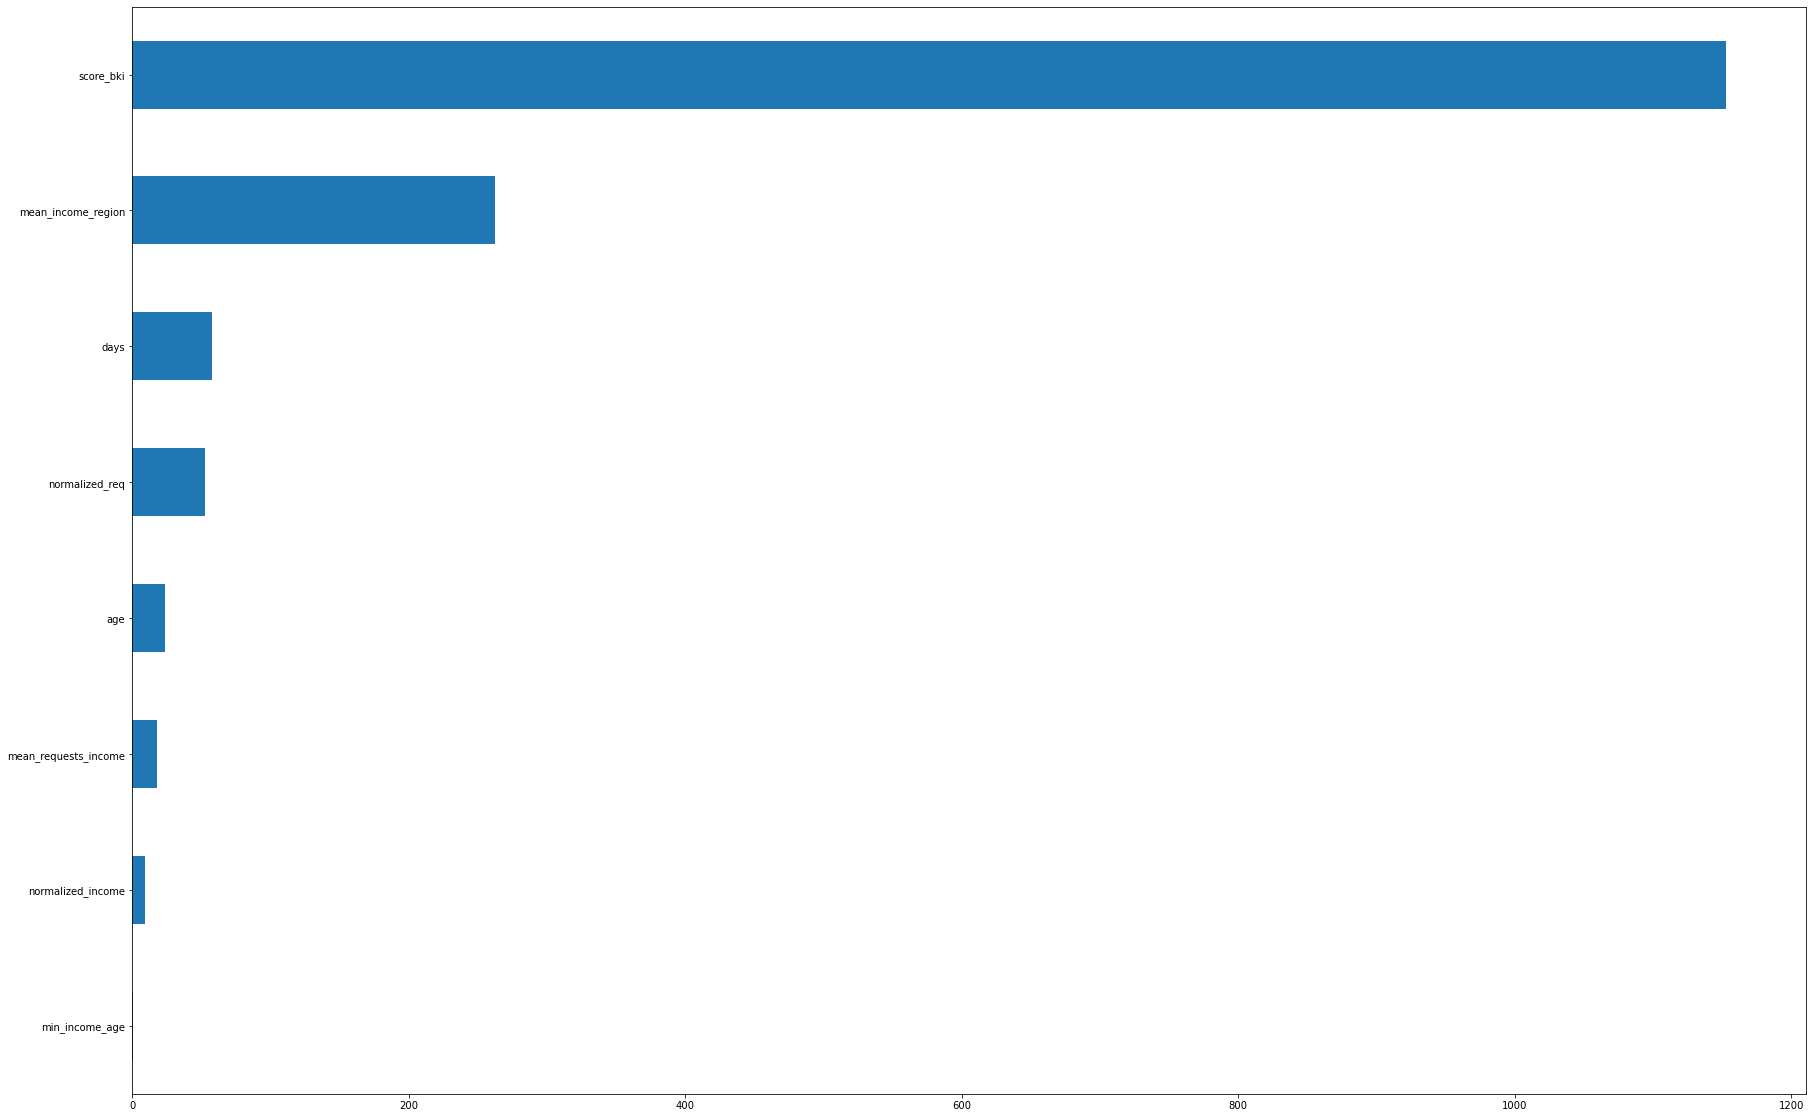

In [37]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

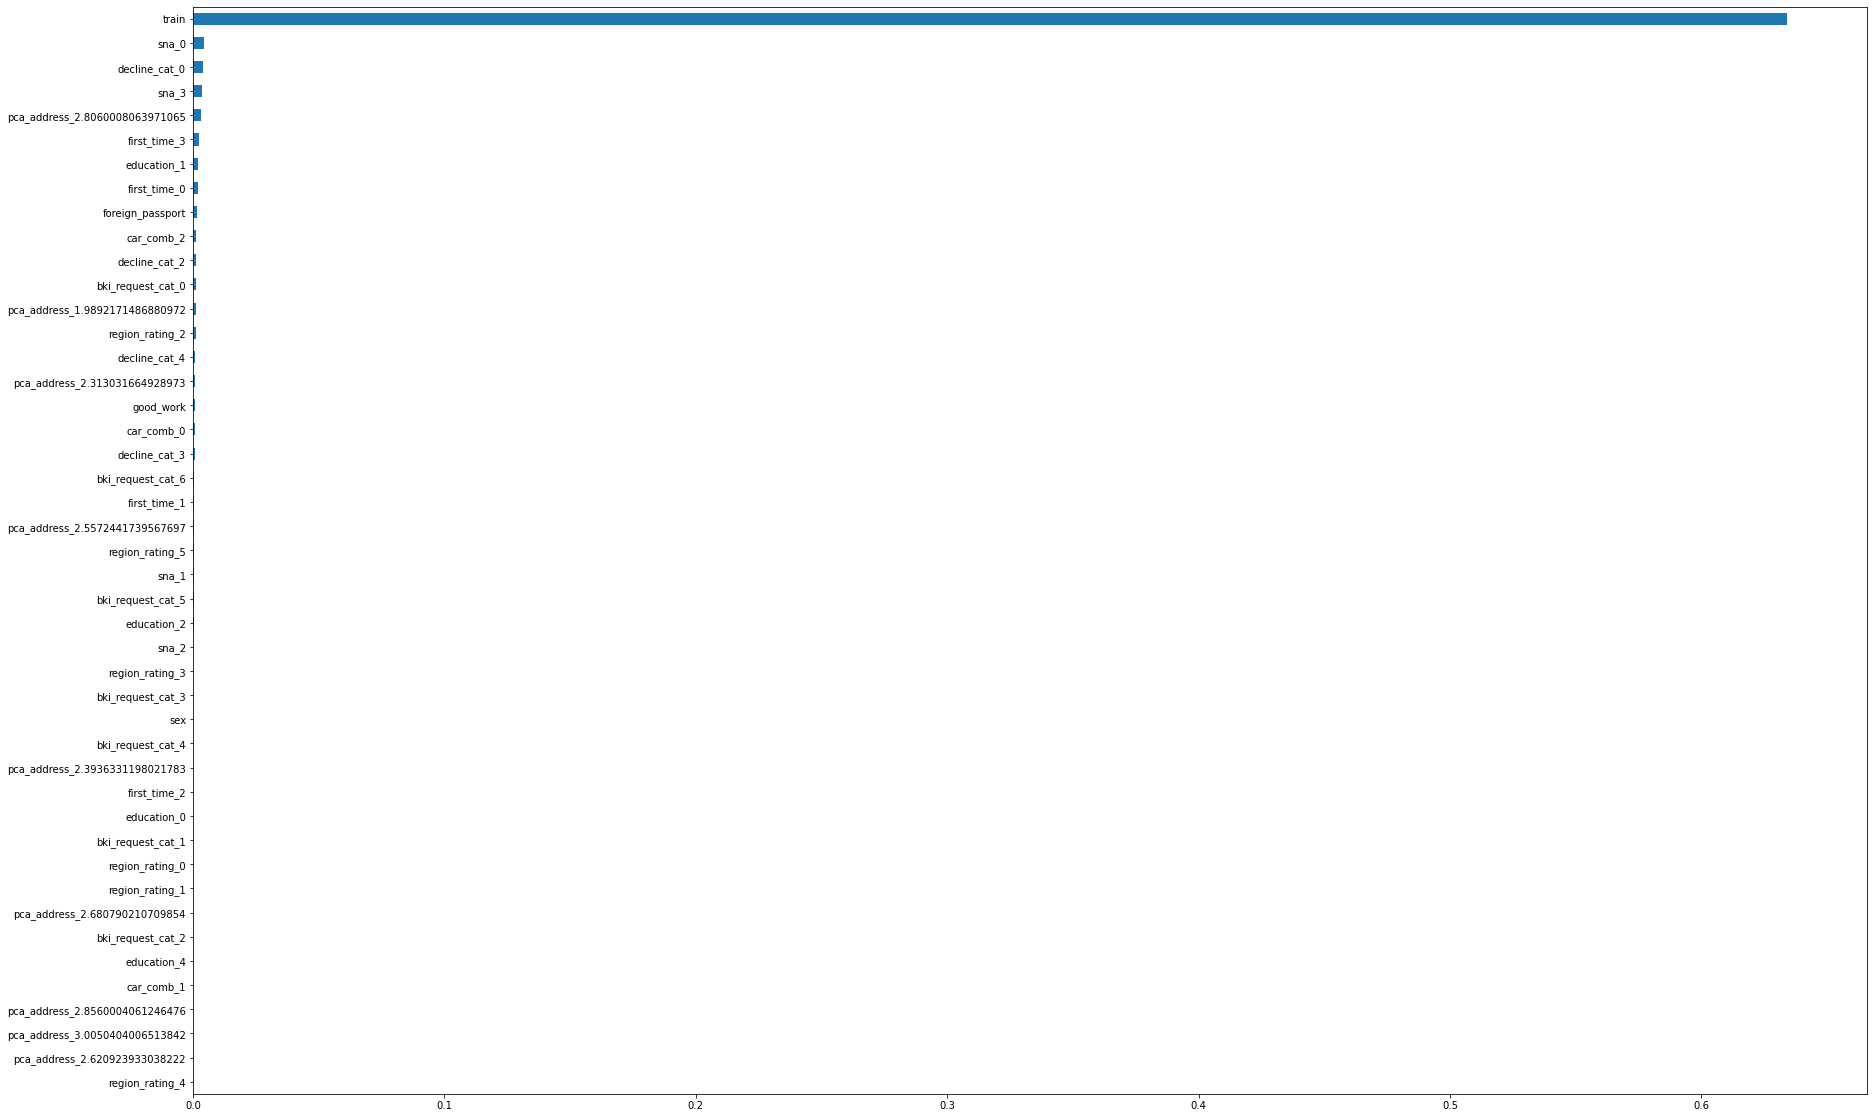

In [38]:
imp_cat = Series(mutual_info_classif(data[bin_cols], data['default'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Убирать признаки не будем так как есть сильное статистическое влияние на целевую переменную у большинства параметров сгенерированных и из датасета.

### Моделирование

In [39]:
df = data

In [40]:
X = df[df['train']==1].drop(['client_id', 'train', 'default'], axis = 1)

In [41]:
Y=  df[df['train']==1]['default'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [43]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

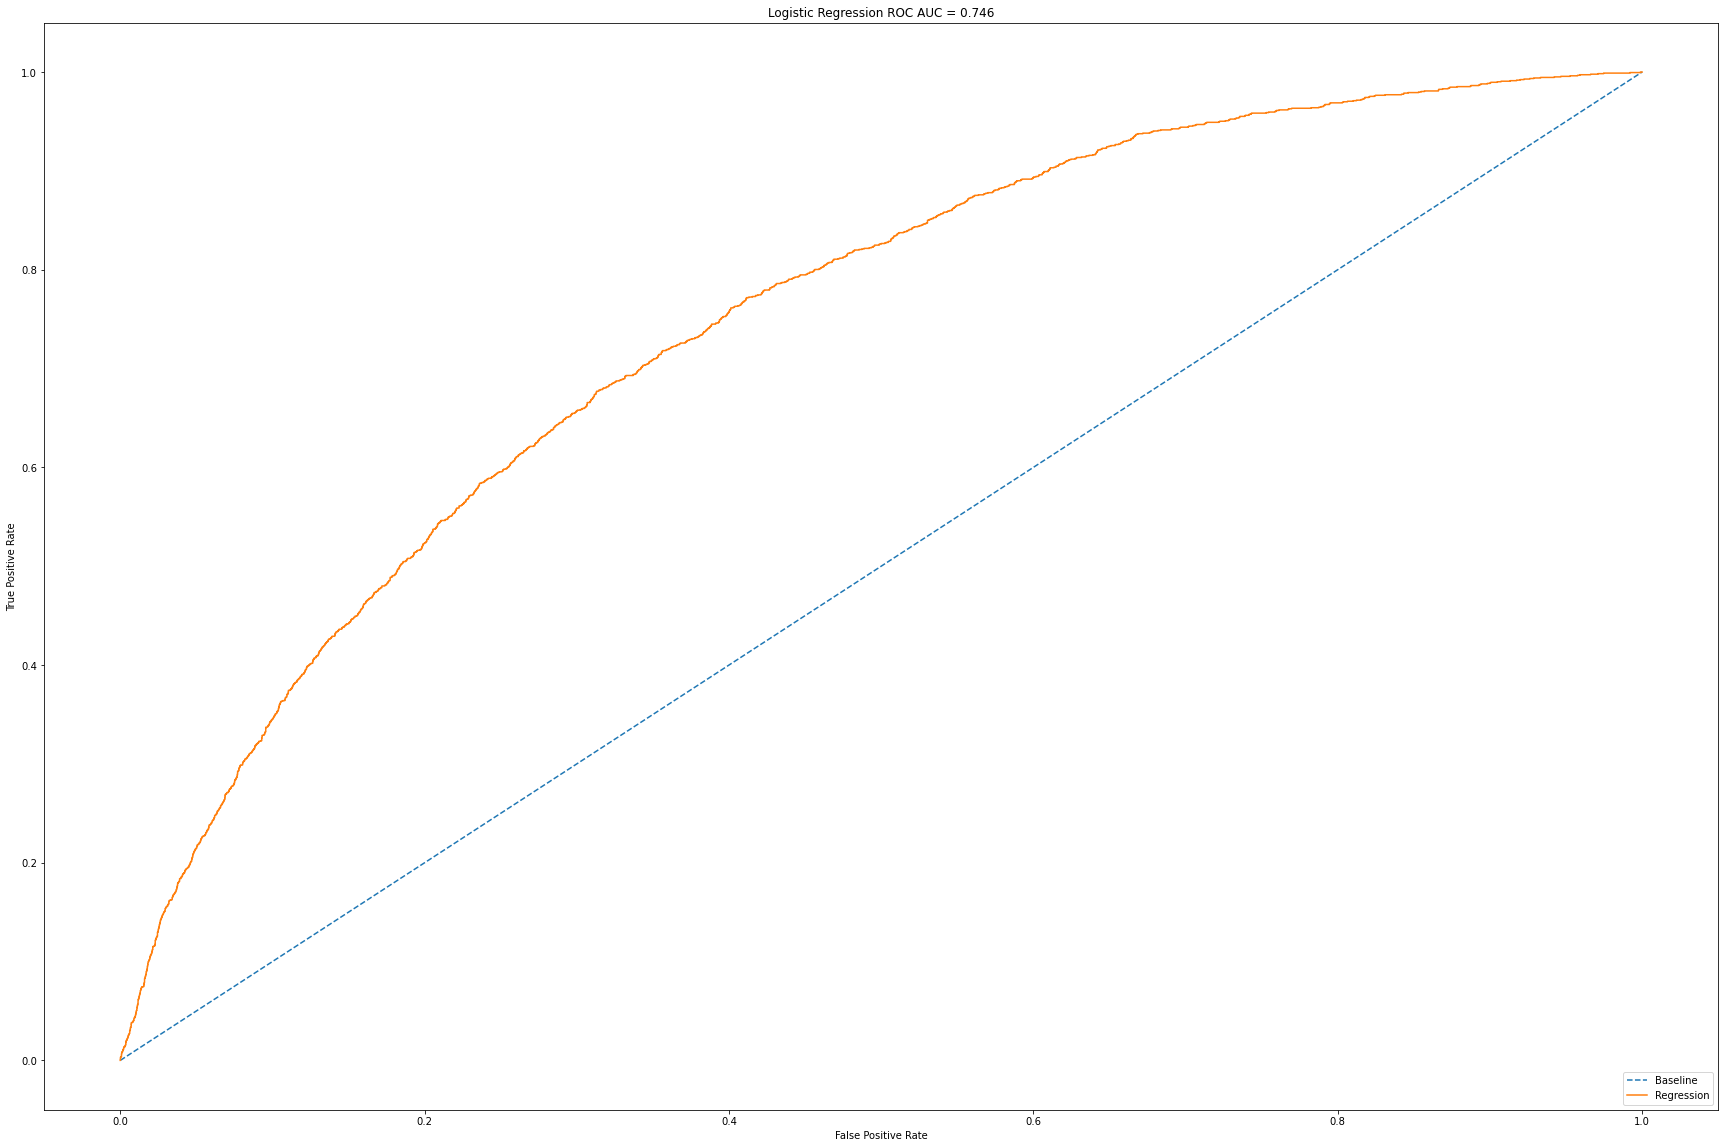

accuracy_score:		 0.8749
precision_score:	 0.4
recall_score:		 0.02189
f1_score:		 0.04152
roc_auc_score:		 0.7459
LogisticRegression(max_iter=1000)


<Figure size 2160x1440 with 0 Axes>

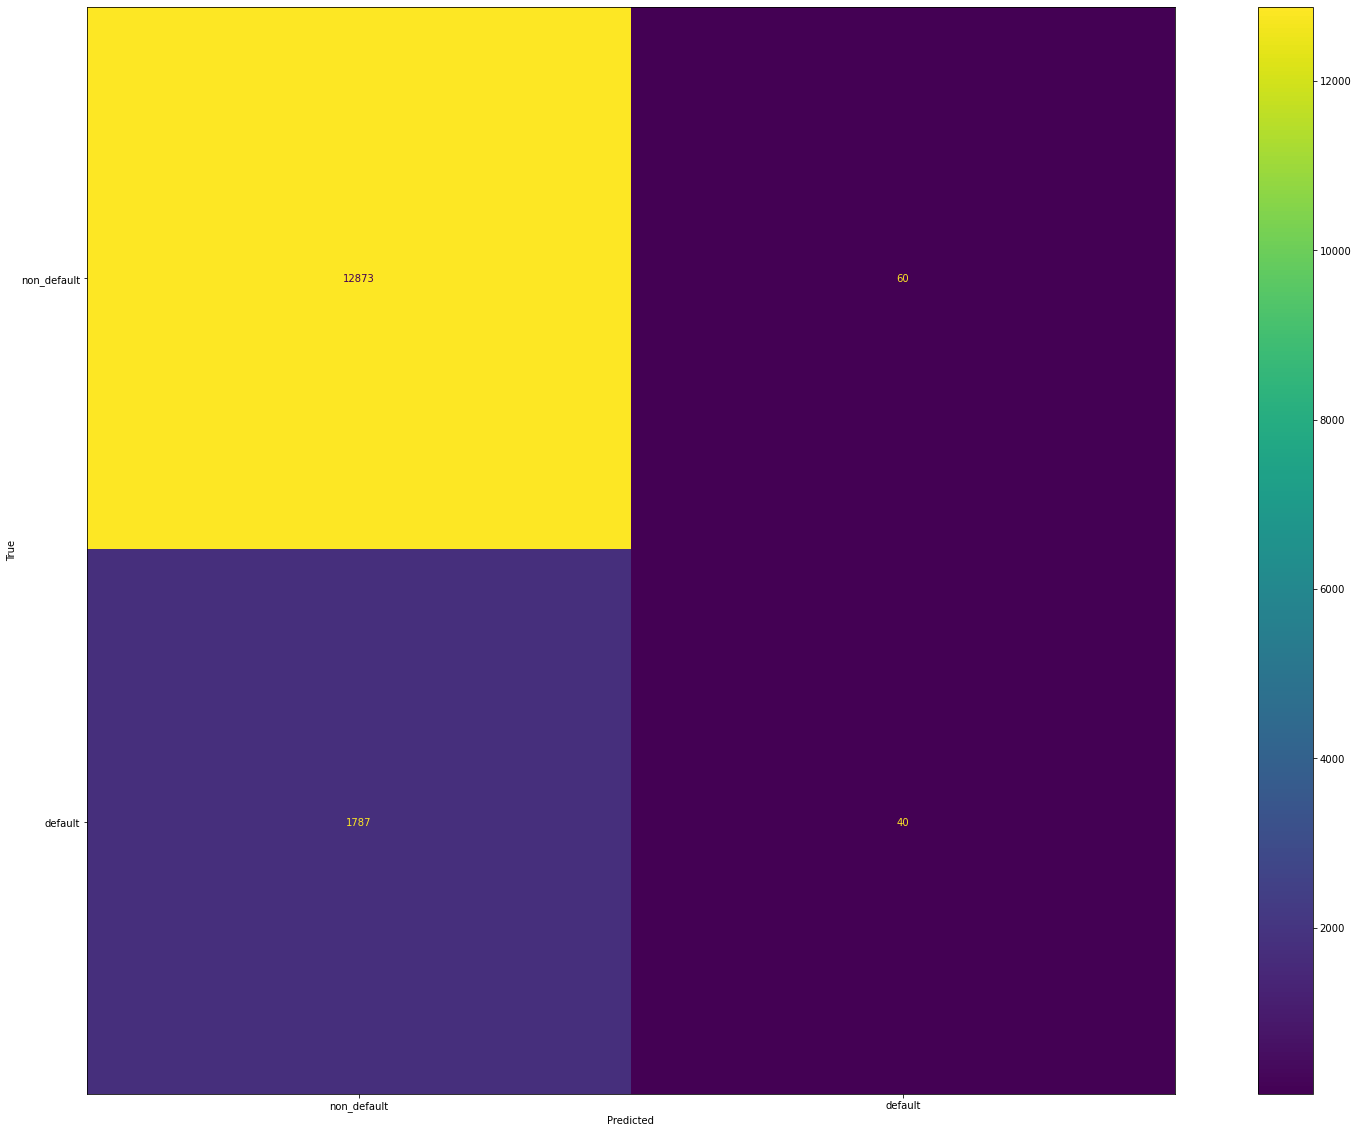

In [44]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

show_metrics(y_test, y_pred, probs)

conf_matrix(y_test, y_pred, model)

Построим модель после проведенных изменений


В наивной модели мы вообще ничего не угадали из дефолтных клиентов. Вероятность угадывания примерно такая же как при подбрасывании монетки. Но так как благонадежных заемщиков всетаки больше, чем неблагонадежных, модель показывает высокий уровень точности.

accuracy_score: 0.8762

precision_score: 0.0

recall_score: 0.0

f1_score: 0.0

roc_auc_score: 0.5517

После обработки признаков мы получили:

accuracy_score:		 0.8749

precision_score:	 0.4

recall_score:		 0.02189

f1_score:		 0.04152

roc_auc_score:		 0.7459

Чего не хватает в данных, так это величны заема который делали клиенты (возможно уже включено в рейтинг БКИ).
Банку важно не упустить тех кто выплатить кредит и тех, кто не выплатит в случае одобрения.

Добавление дополнительных признаков улучшило определение дефолтных клиентов с 0 до 40. Подросли другие метрики. Но это не достаточно.

ПОработем с моделью.

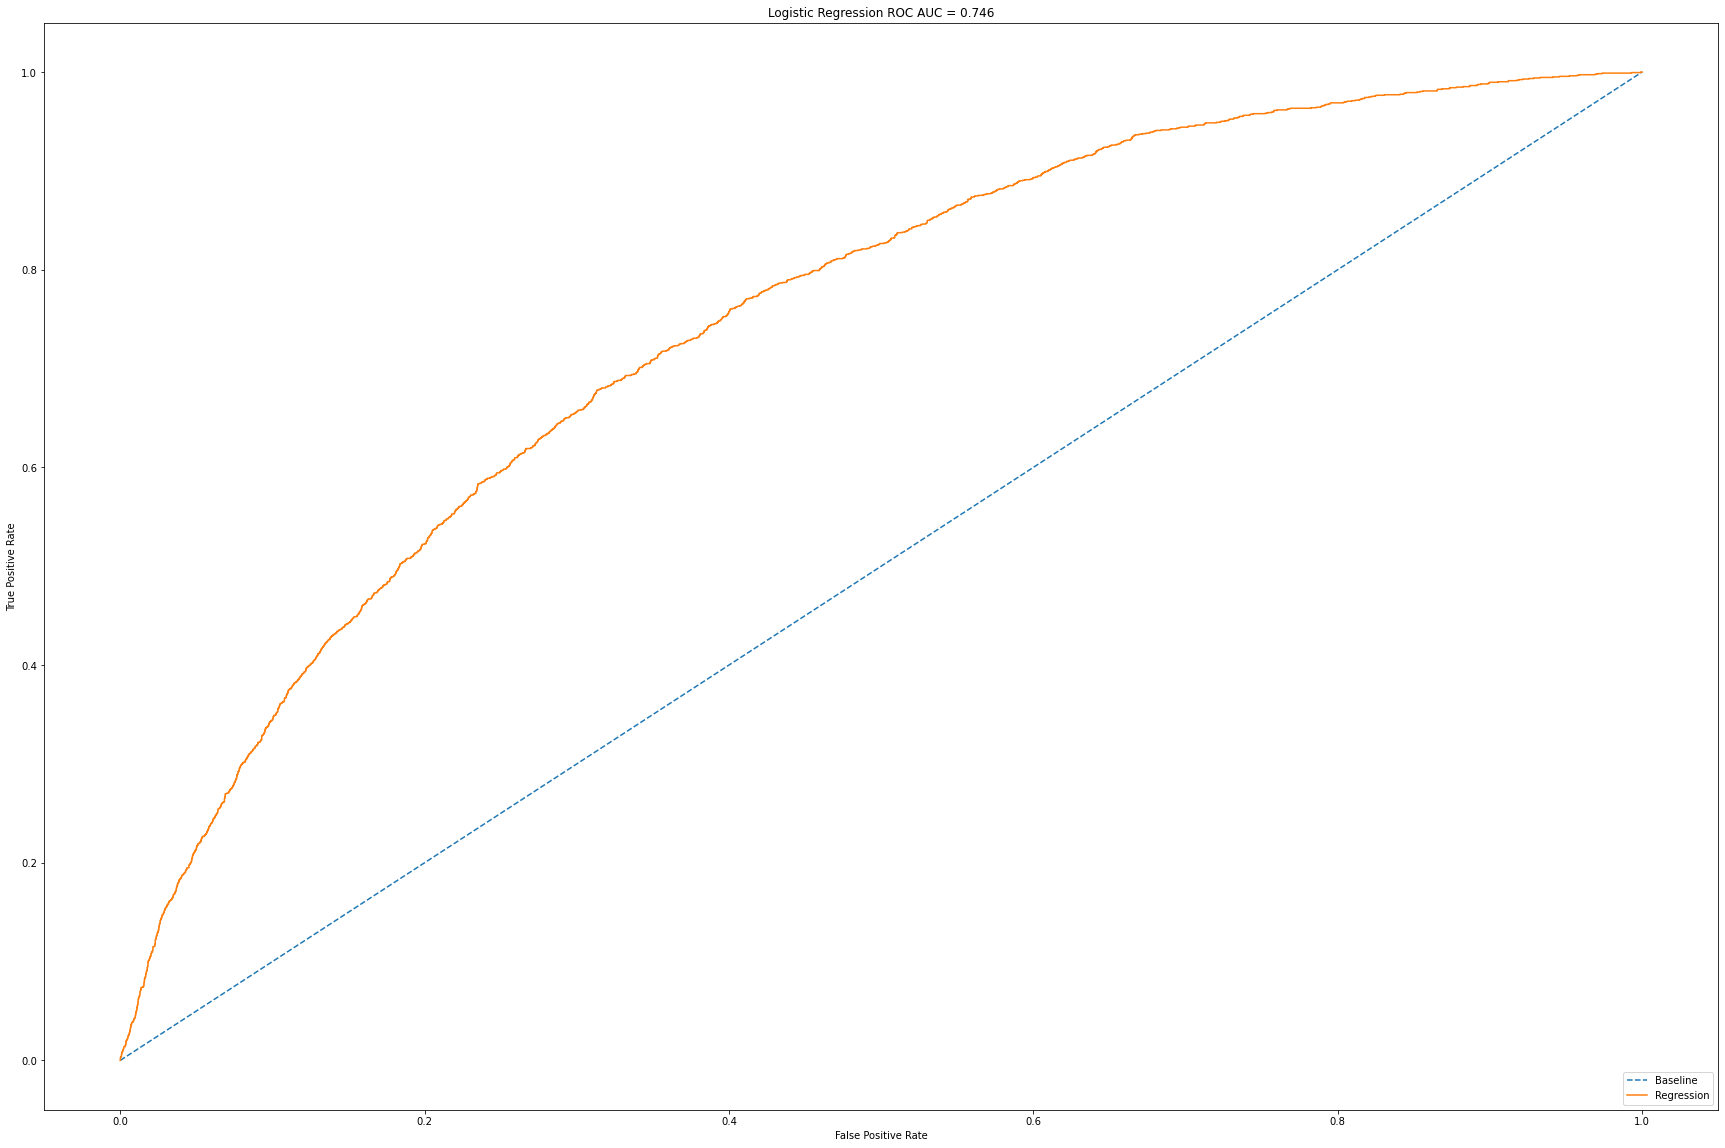

accuracy_score:		 0.8748
precision_score:	 0.396
recall_score:		 0.02189
f1_score:		 0.04149
roc_auc_score:		 0.7458
LogisticRegression(max_iter=1000, penalty='none')


<Figure size 2160x1440 with 0 Axes>

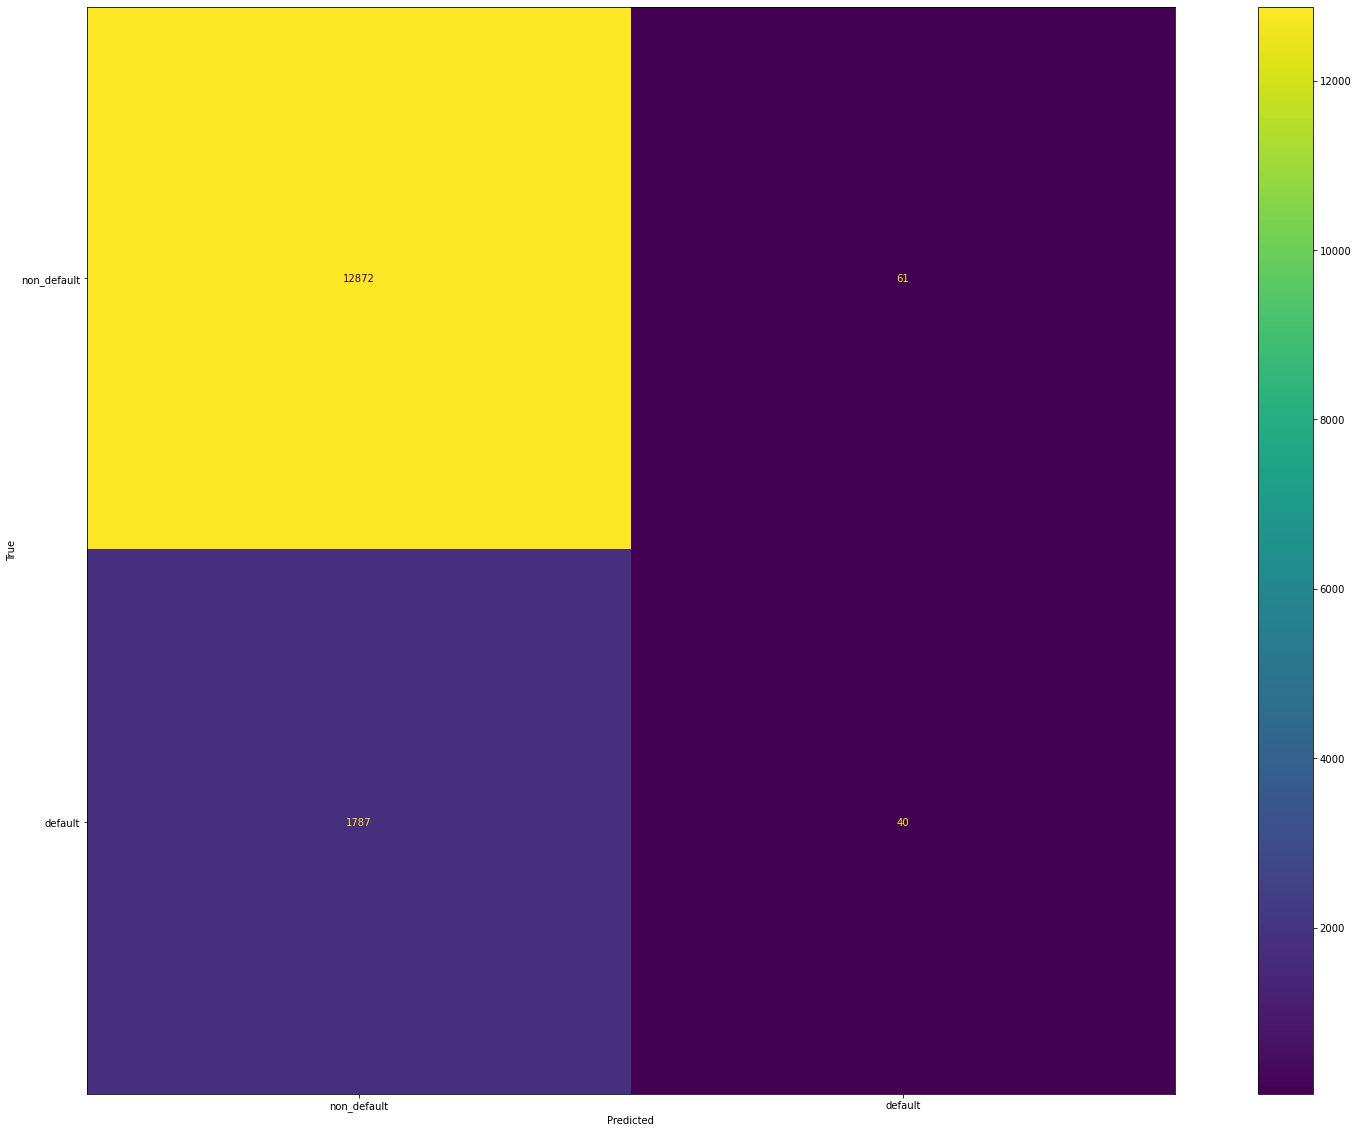

In [45]:
# penalty=none is stronger than penalty=l2

model = LogisticRegression(penalty='none', max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

show_metrics(y_test, y_pred, probs)

conf_matrix(y_test, y_pred, model)




В наивной модели мы вообще ничего не угадали из дефолтных клиентов. Вероятность угадывания примерно такая же как при подбрасывании монетки. Но так как благонадежных заемщиков всетаки больше, чем неблагонадежных, модель показывает высокий уровень точности.

accuracy_score: 0.8762

precision_score: 0.0

recall_score: 0.0

f1_score: 0.0

roc_auc_score: 0.5517

После обработки признаков мы получили:

accuracy_score:		 0.8749

precision_score:	 0.4

recall_score:		 0.02189

f1_score:		 0.04152

roc_auc_score:		 0.7459

Регрессия с penalty='none' дает:

accuracy_score:		 0.8748

precision_score:	 0.396

recall_score:		 0.02189

f1_score:		 0.04149

roc_auc_score:		 0.7458

LogisticRegression(max_iter=1000, penalty='none'), и также 40 определенных дефолтных их почти 1800.

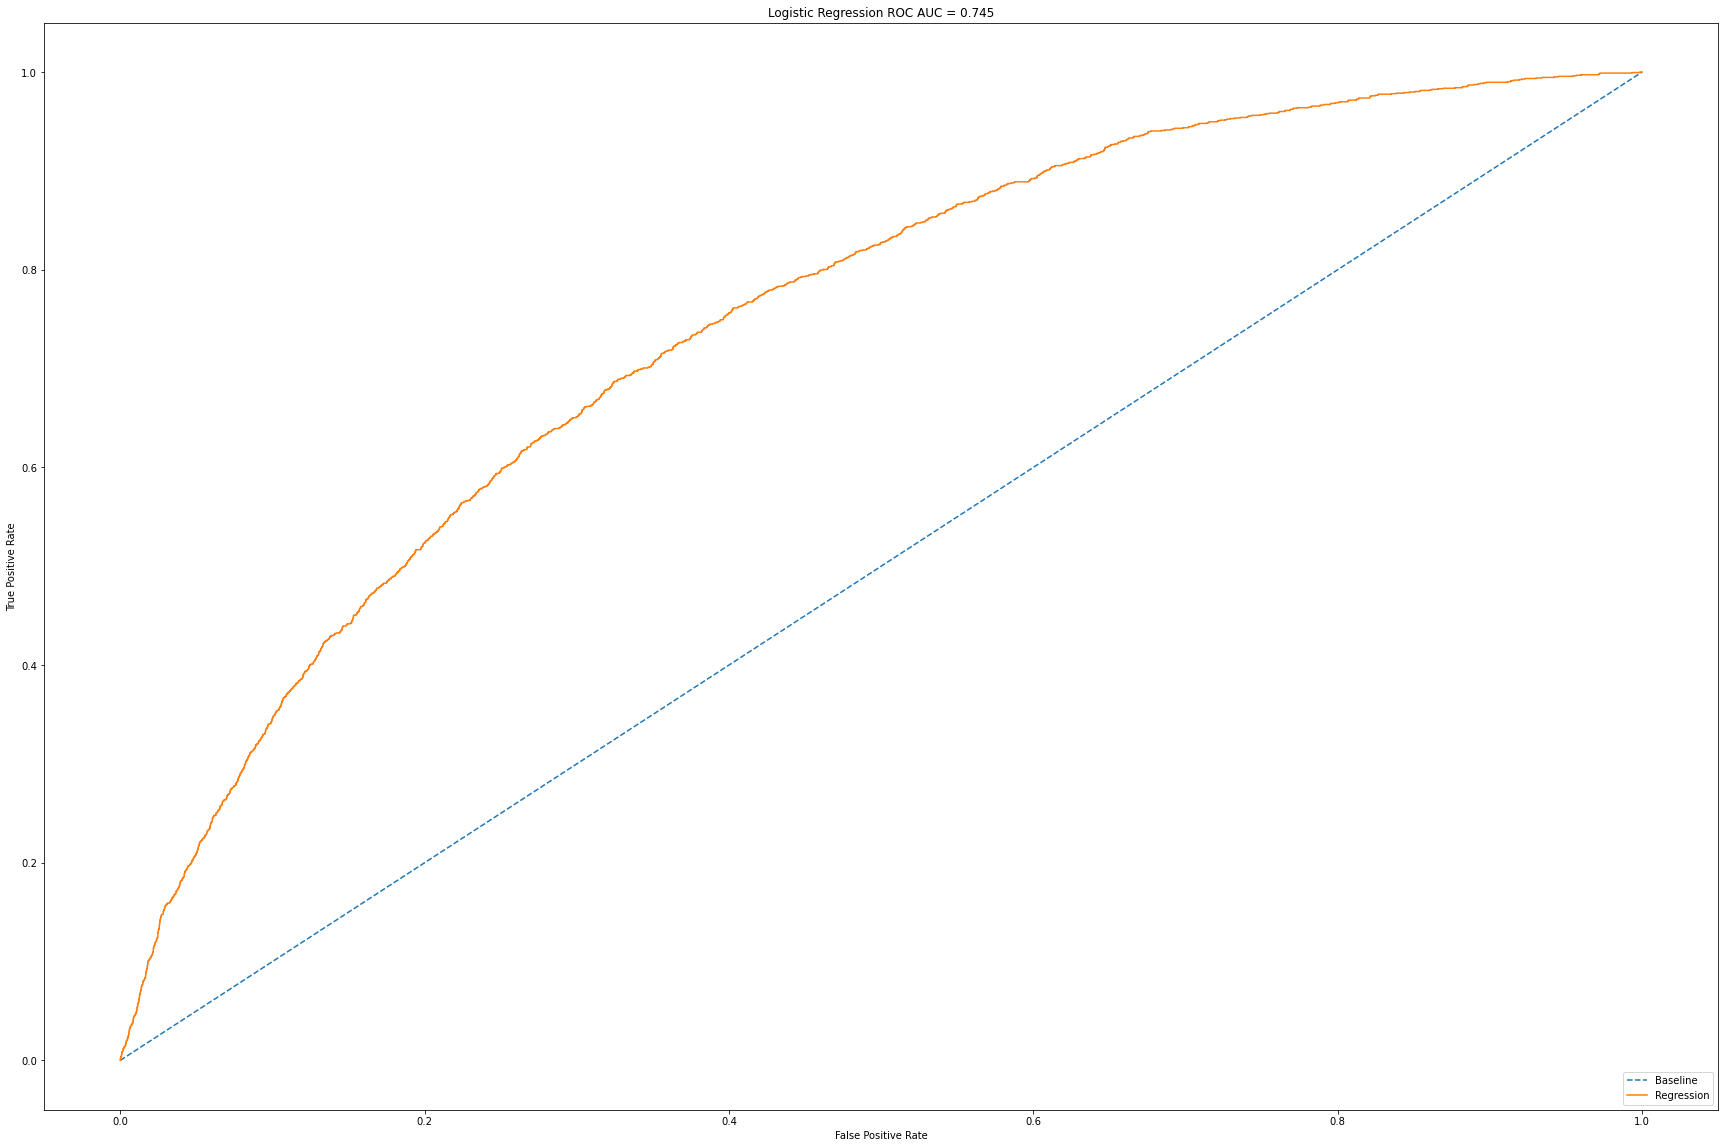

accuracy_score:		 0.6713
precision_score:	 0.2276
recall_score:		 0.6913
f1_score:		 0.3424
roc_auc_score:		 0.7453
LogisticRegression(class_weight='balanced', max_iter=1000)


<Figure size 2160x1440 with 0 Axes>

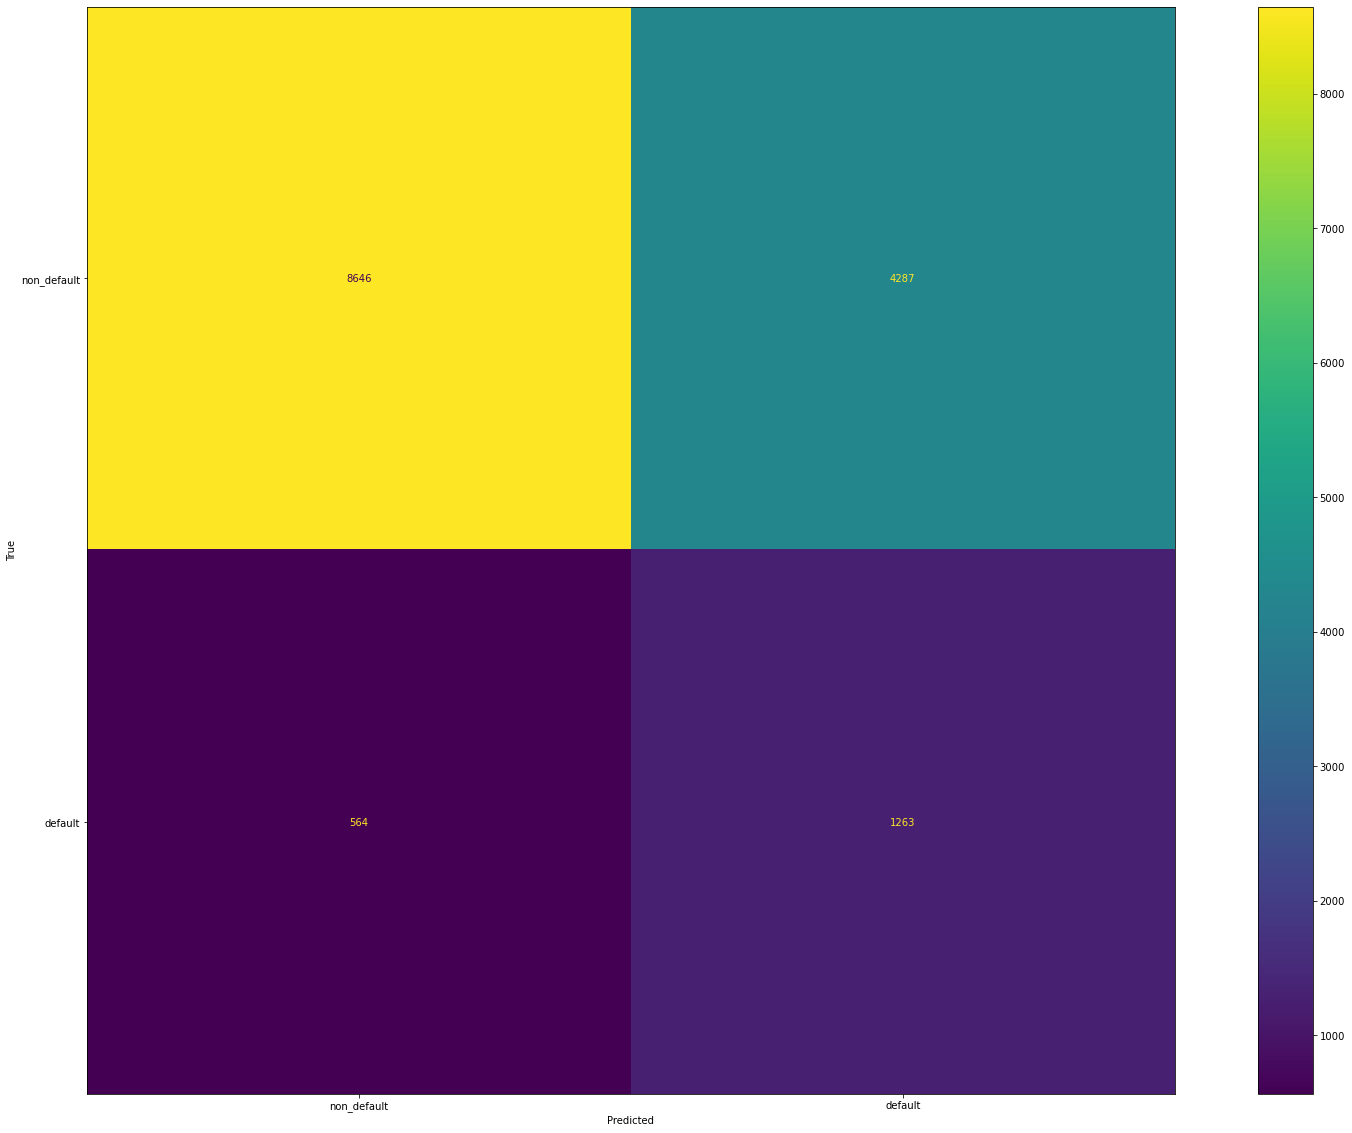

In [46]:
# balanced data


model = LogisticRegression(class_weight='balanced', max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

show_metrics(y_test, y_pred, probs)

conf_matrix(y_test, y_pred, model)



Значительно выросло чисол клиентов ,которых определили как дефолтных! Метрика f1 выросла занчительно! Балансировка определнно нужна в модели.
accuracy_score:		 0.6713

precision_score:	 0.2276

recall_score:		 0.6913

f1_score:		 0.3424

roc_auc_score:		 0.7453

LogisticRegression(class_weight='balanced', max_iter=1000)

### Подбор гиперпараметров

In [47]:
from sklearn.model_selection import GridSearchCV
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear', max_iter = 1000)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 1.0


Моделирование с гиперпараметрами, запись в файл.

In [48]:
data.head()

,client_id,sex,age,good_work,score_bki,foreign_passport,default,train,days,min_income_age,...,bki_request_cat_6,pca_address_1.9892171486880972,pca_address_2.313031664928973,pca_address_2.3936331198021783,pca_address_2.5572441739567697,pca_address_2.620923933038222,pca_address_2.680790210709854,pca_address_2.8060008063971065,pca_address_2.8560004061246476,pca_address_3.0050404006513842
0,25905,1,62,0,-0.126966,0,0,1,-0.553571,0.384615,...,0,0,1,0,0,0,0,0,0,0
1,63161,0,59,0,0.561041,0,0,1,0.142857,-0.769231,...,0,0,0,0,0,0,0,1,0,0
2,25887,1,25,0,0.740284,1,0,1,-0.553571,-1.153846,...,0,0,1,0,0,0,0,0,0,0
3,16222,0,53,0,-0.197313,0,0,1,-0.714286,0.384615,...,0,0,0,0,0,0,0,1,0,0
4,101655,1,48,1,0.976254,1,0,1,0.803571,0.384615,...,0,0,0,0,0,0,0,1,0,0


In [53]:
df = data
X = df[df['train']==1].drop(['client_id', 'train', 'default'], axis = 1)
Y=  df[df['train']==1]['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

model = LogisticRegression(penalty = 'l1', solver = 'liblinear', class_weight='balanced',max_iter = 1000, C = 1)
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

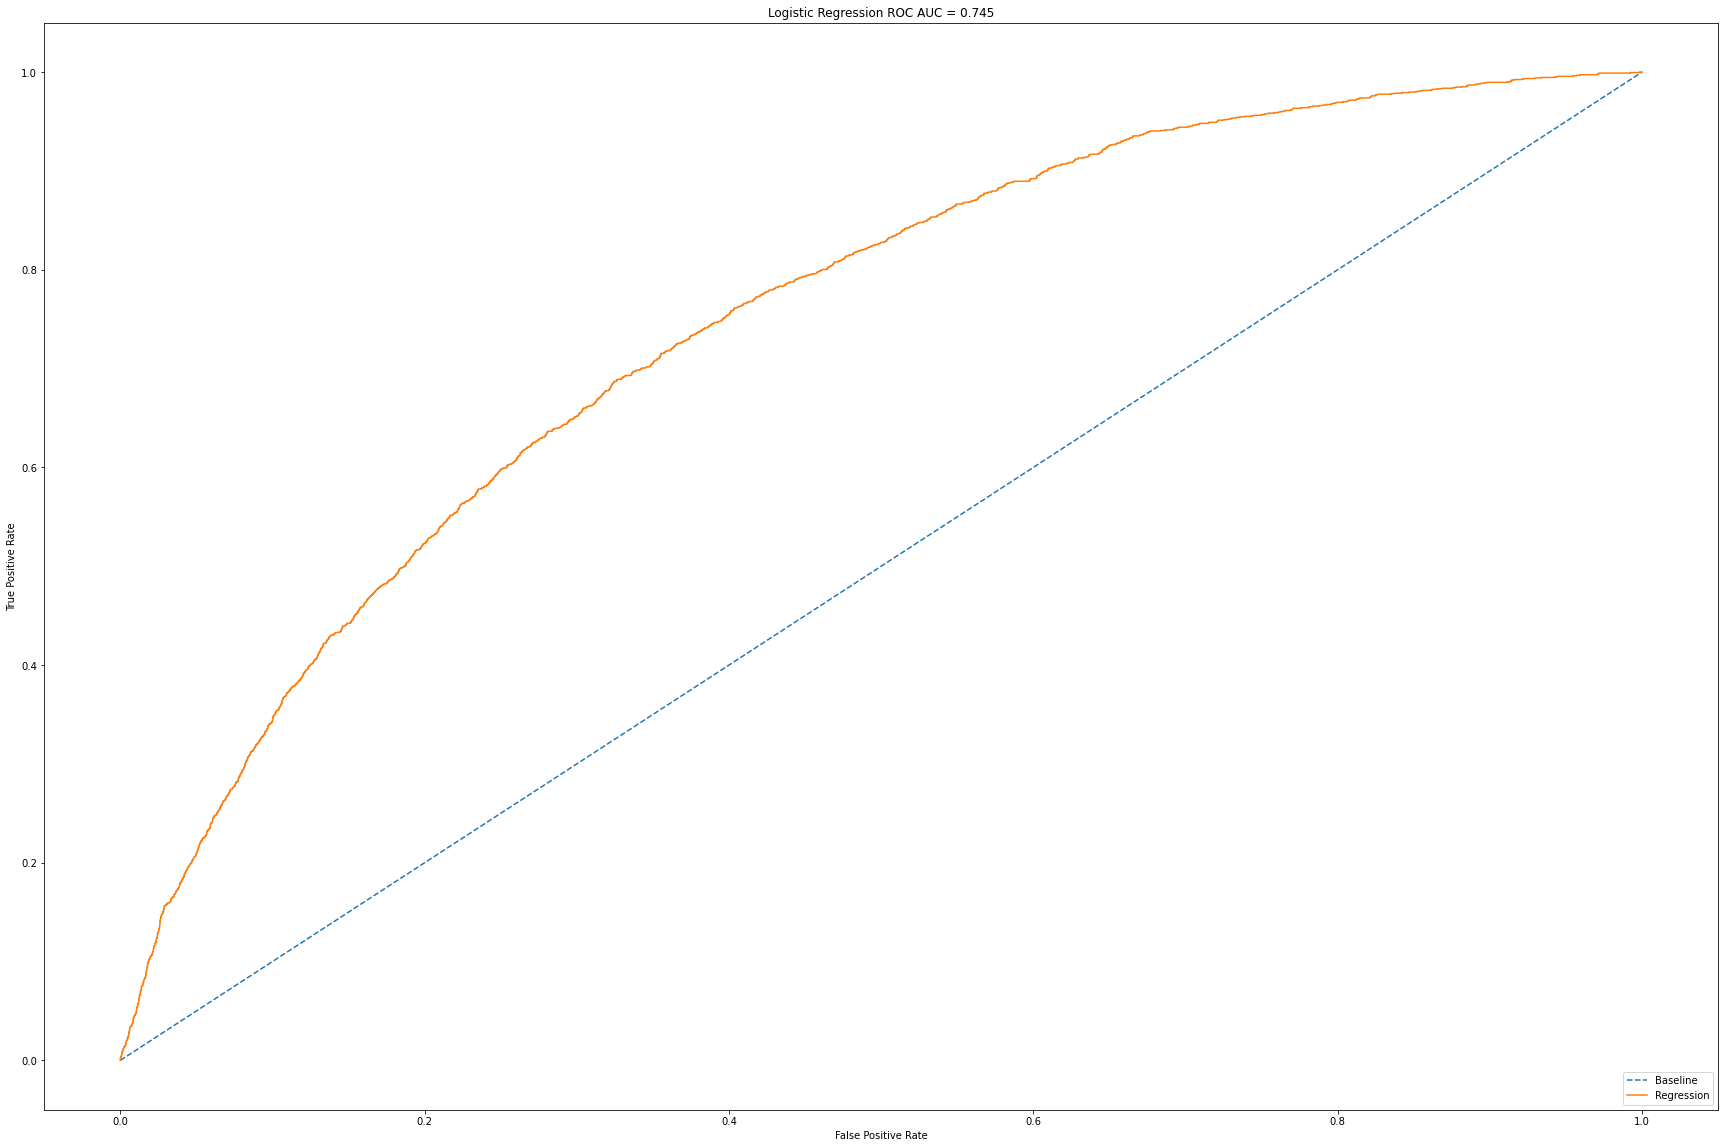

accuracy_score:		 0.6715
precision_score:	 0.2277
recall_score:		 0.6918
f1_score:		 0.3427
roc_auc_score:		 0.7454
LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')


<Figure size 2160x1440 with 0 Axes>

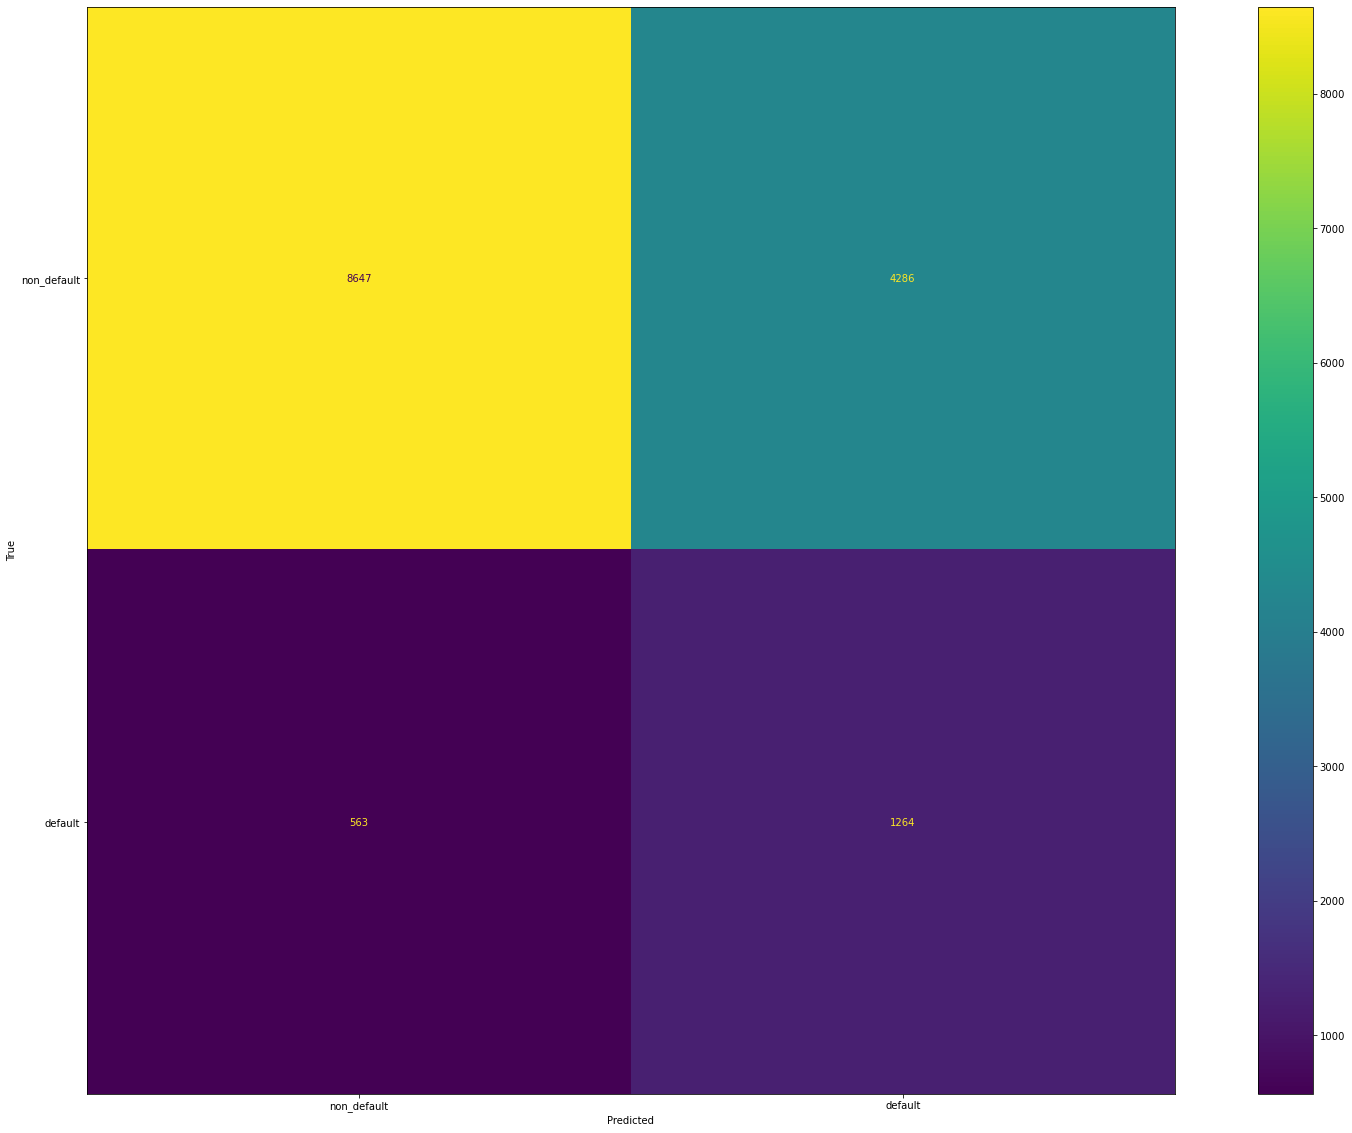

In [54]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

show_metrics(y_test, y_pred, probs)

conf_matrix(y_test, y_pred, model)

Получилось посмотреть модель Линейной Регрессии для классификации потенциальных клиентов банка и выдачу креитов (ответ - верочтноять того, что клинет - дефолтный).

Модель выдала следующие качетсвенные характеристики:

    accuracy_score:		 0.6715
    precision_score:	 0.2277
    recall_score:		 0.6918
    f1_score:		 0.3427
    roc_auc_score:		 0.7454
Сама модель

    LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                       solver='liblinear')
                       
Получилось оптимизировать гиперпараметры (долго не считалось), понять что балансировка данных очень важна. Дисбаланс в целевой функции играет очень важную роль. Оптимальный парамет для оценки качества модели - это вся матрица и f1 score. Та как тут можно оценить ошибки первого и второго рода. В целом, я бы такую модель не отдавала в работу, так как предстказательная сопсобность дефолтных клинетов на данных не очень. (1264 з около 1800, что в любом случае значительно лучше чем изначальные 40 из 1800).

In [52]:
y_pred = model.predict_proba(X_test)
results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
results_df.to_csv('submission.csv', index=False)
results_df

In [56]:
data[data['train'] == 0]

,client_id,sex,age,good_work,score_bki,foreign_passport,default,train,days,min_income_age,...,bki_request_cat_6,pca_address_1.9892171486880972,pca_address_2.313031664928973,pca_address_2.3936331198021783,pca_address_2.5572441739567697,pca_address_2.620923933038222,pca_address_2.680790210709854,pca_address_2.8060008063971065,pca_address_2.8560004061246476,pca_address_3.0050404006513842
73799,74835,1,29,0,-0.506914,0,-1,0,0.321429,0.384615,...,0,0,1,0,0,0,0,0,0,0
73800,17527,0,39,0,0.600428,0,-1,0,-0.696429,0.000000,...,0,0,1,0,0,0,0,0,0,0
73801,75683,1,50,0,0.331363,1,-1,0,0.339286,0.384615,...,0,0,1,0,0,0,0,0,0,0
73802,26883,1,56,0,-0.654628,0,-1,0,-0.517857,-0.596154,...,0,0,1,0,0,0,0,0,0,0
73803,28862,0,38,0,-0.818256,0,-1,0,-0.500000,0.376923,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,0,37,0,0.253914,0,-1,0,0.482143,0.384615,...,0,0,0,0,0,0,0,1,0,0
110144,106254,0,64,0,-0.538533,0,-1,0,0.928571,0.000000,...,0,0,1,0,0,0,0,0,0,0
110145,81852,1,31,0,1.415172,0,-1,0,0.464286,-0.384615,...,0,0,1,0,0,0,0,0,0,0
110146,1971,0,27,0,0.979620,0,-1,0,-1.000000,-0.615385,...,0,0,0,0,0,0,0,1,0,0


In [59]:
X_test = data[data['train'] == 0].drop(['client_id', 'train', 'default'], axis = 1)
y_test = data[data['train'] == 0].default.values

In [62]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]


In [63]:
submit = pd.DataFrame(data[data['train'] == 0].client_id)
submit['default']=probs
submit.to_csv('submission.csv', index=False)